In [19]:
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import networkx as nx
import community.community_louvain as community_louvain
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from networkx.algorithms.community import girvan_newman, greedy_modularity_communities, modularity
import infomap
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.spatial.distance import pdist, squareform

In [20]:
# Load dataset
dataset = load_dataset("RealTimeData/bbc_news_alltime", "2017-01")
texts = [item["content"] for item in dataset["train"] if item["content"]]


In [21]:
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(texts[:200], show_progress_bar=True)

Loading weights: 100%|██████████| 103/103 [00:00<00:00, 506.78it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Batches: 100%|██████████| 7/7 [00:16<00:00,  2.39s/it]


In [22]:
similarity_matrix = cosine_similarity(embeddings)
threshold = 0.5
G = nx.Graph()

for i in range(len(embeddings)):
    for j in range(i+1, len(embeddings)):
        if similarity_matrix[i, j] > threshold:
            G.add_edge(i, j, weight=similarity_matrix[i, j])

In [23]:
partition_louvain = community_louvain.best_partition(G, weight="weight")

clusters_louvain = {}
for node, comm in partition_louvain.items():
    clusters_louvain.setdefault(comm, []).append(texts[node])

In [24]:
gn_generator = girvan_newman(G)
first_level_communities = next(gn_generator)   # first split
partition_gn = {}
for comm_id, community_nodes in enumerate(first_level_communities):
    for node in community_nodes:
        partition_gn[node] = comm_id

clusters_gn = {}
for node, comm in partition_gn.items():
    clusters_gn.setdefault(comm, []).append(texts[node])


In [25]:
def run_infomap(graph):
    """Run Infomap algorithm on NetworkX graph"""
    im = infomap.Infomap("--two-level --directed")

    # Add nodes and edges to Infomap
    for node in graph.nodes():
        im.add_node(node)

    for edge in graph.edges(data=True):
        weight = edge[2].get('weight', 1.0)
        im.add_link(edge[0], edge[1], weight)

    # Run algorithm
    im.run()

    # Extract partition
    partition = {}
    for node in im.tree:
        if node.is_leaf:
            partition[node.node_id] = node.module_id

    return partition

In [26]:
partition_infomap = run_infomap(G)

clusters_infomap = {}
for node, comm in partition_infomap.items():
    clusters_infomap.setdefault(comm, []).append(texts[node])

  Infomap v2.8.1 starts at 2026-02-23 18:53:33
  -> Input network: 
  -> No file output!
  -> Configuration: two-level
                    directed
  OpenMP 201511 detected with 1 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'directed'... 
  -> Using unrecorded teleportation to links. 
  -> PageRank calculation done in 50 iterations.

  => Sum node flow: 1, sum link flow: 1
Build internal network with 89 nodes and 147 links...
  -> One-level codelength: 5.65969708

Trial 1/1 starting at 2026-02-23 18:53:33
Two-level compression: 46% 2% 
Partitioned to codelength 0.362542851 + 2.65000887 = 3.012551722 in 20 modules.

=> Trial 1/1 finished in 0.001171148s with codelength 3.01255172


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [         20,           0] (sum: 20)
Per level number of leaf nodes:      [          0,          89] (sum: 89)
Per

In [27]:
def extract_keywords(clusters):
    community_keywords = {}
    vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
    for comm, docs in clusters.items():
        if docs:  # Check if docs is not empty
            X = vectorizer.fit_transform(docs)
            scores = X.toarray().mean(axis=0)
            top_indices = scores.argsort()[-3:][::-1]  # Reduced to top 3 keywords
            keywords = [vectorizer.get_feature_names_out()[i] for i in top_indices]
            community_keywords[comm] = ", ".join(keywords)
        else:
            community_keywords[comm] = "No keywords"
    return community_keywords

# Extract keywords for all algorithms
community_keywords_louvain = extract_keywords(clusters_louvain)
community_keywords_gn = extract_keywords(clusters_gn)
community_keywords_infomap = extract_keywords(clusters_infomap)

In [28]:
def create_better_layout(G, partition):
    """Create a layout that spreads communities better"""
    # Use force-directed layout with more iterations and better parameters
    pos = nx.spring_layout(G, k=2.0, iterations=100, seed=42)

    # Post-process positions to spread communities further apart
    communities = {}
    for node, comm in partition.items():
        if comm not in communities:
            communities[comm] = []
        communities[comm].append(node)

    # Calculate community centers and spread them out
    comm_centers = {}
    for comm, nodes in communities.items():
        if nodes:
            center_x = np.mean([pos[node][0] for node in nodes])
            center_y = np.mean([pos[node][1] for node in nodes])
            comm_centers[comm] = (center_x, center_y)

    # Spread community centers in a circle
    num_comms = len(comm_centers)
    if num_comms > 1:
        angles = np.linspace(0, 2*np.pi, num_comms, endpoint=False)
        radius = 3.0  # Increased radius for better separation

        for i, comm in enumerate(comm_centers.keys()):
            center_offset_x = radius * np.cos(angles[i])
            center_offset_y = radius * np.sin(angles[i])

            # Move all nodes in this community
            old_center = comm_centers[comm]
            for node in communities[comm]:
                pos[node] = (pos[node][0] - old_center[0] + center_offset_x,
                           pos[node][1] - old_center[1] + center_offset_y)

    return pos

In [29]:
pos_louvain = create_better_layout(G, partition_louvain)
pos_gn = create_better_layout(G, partition_gn)
pos_infomap = create_better_layout(G, partition_infomap)

In [30]:
colors = [partition_louvain[node] for node in G.nodes()]
unique_comms = sorted(set(colors))
num_comms = len(unique_comms)

width = max(28, num_comms * 2)  # Increased width for 4 subplots
plt.figure(figsize=(width, 16))


<Figure size 3200x1600 with 0 Axes>

<Figure size 3200x1600 with 0 Axes>

Text(0.5, 1.0, 'Louvain Algorithm')

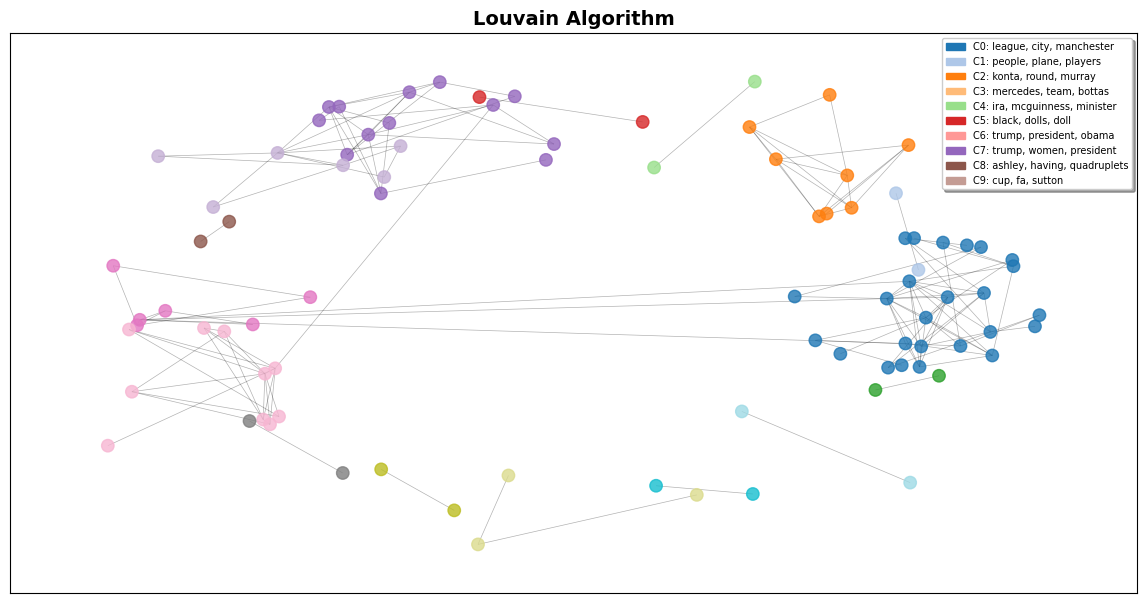

In [31]:
colors = [partition_louvain[node] for node in G.nodes()]
unique_comms = sorted(set(colors))
num_comms = len(unique_comms)

width = max(28, num_comms * 2)  # Increased width for 4 subplots
plt.figure(figsize=(width, 16))
plt.subplot(2, 2, 1)
nx.draw_networkx_nodes(G, pos_louvain, node_size=80, node_color=colors, 
                      cmap=plt.cm.tab20, alpha=0.8)
nx.draw_networkx_edges(G, pos_louvain, alpha=0.3, width=0.5, edge_color='black')

patches = []
for i in unique_comms[:min(10, len(unique_comms))]:
    if i in community_keywords_louvain:
        keywords = community_keywords_louvain[i]
        if len(keywords) > 30:
            keywords = keywords[:27] + "..."
        patches.append(mpatches.Patch(
            color=plt.cm.tab20(i/len(unique_comms)),
            label=f"C{i}: {keywords}"
        ))

colors = [partition_louvain[node] for node in G.nodes()]
unique_comms = sorted(set(colors))
num_comms = len(unique_comms)
plt.legend(handles=patches, loc="upper right", bbox_to_anchor=(1.0, 1.0), 
          fontsize=7, frameon=True, fancybox=True, shadow=True)
plt.title("Louvain Algorithm", fontsize=14, fontweight='bold')
# plt.axis("off")

(np.float64(-4.675635760638028),
 np.float64(4.7500592483456785),
 np.float64(-4.2695154569004465),
 np.float64(4.322359129580766))

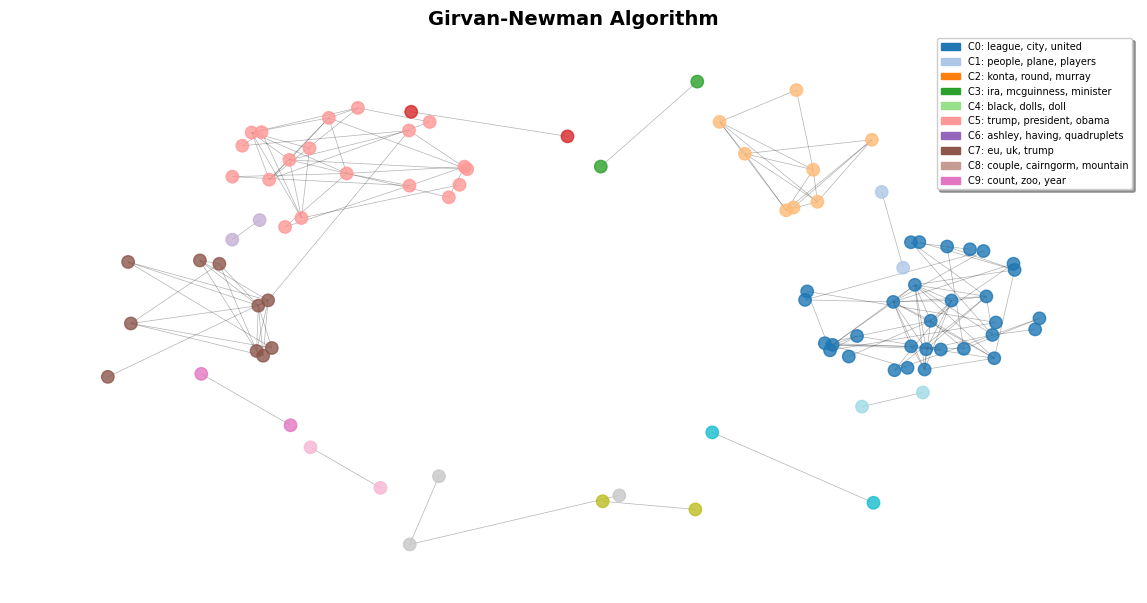

In [32]:
colors = [partition_louvain[node] for node in G.nodes()]
unique_comms = sorted(set(colors))
num_comms = len(unique_comms)

width = max(28, num_comms * 2)  # Increased width for 4 subplots
plt.figure(figsize=(width, 16))
plt.subplot(2, 2, 2)
colors = [partition_gn[node] for node in G.nodes()]
unique_comms = sorted(set(colors))
nx.draw_networkx_nodes(G, pos_gn, node_size=80, node_color=colors, 
                      cmap=plt.cm.tab20, alpha=0.8)
nx.draw_networkx_edges(G, pos_gn, alpha=0.3, width=0.5, edge_color='black')

patches = []
for i in unique_comms[:min(10, len(unique_comms))]:
    if i in community_keywords_gn:
        keywords = community_keywords_gn[i]
        if len(keywords) > 30:
            keywords = keywords[:27] + "..."
        patches.append(mpatches.Patch(color=plt.cm.tab20(i/len(unique_comms)),
                                     label=f"C{i}: {keywords}"))

plt.legend(handles=patches, loc="upper right", bbox_to_anchor=(1.0, 1.0), 
          fontsize=7, frameon=True, fancybox=True, shadow=True)
plt.title("Girvan-Newman Algorithm", fontsize=14, fontweight='bold')
plt.axis("off")

(np.float64(-4.419032174213249),
 np.float64(4.266914054922677),
 np.float64(-4.201954193343162),
 np.float64(4.640590767205163))

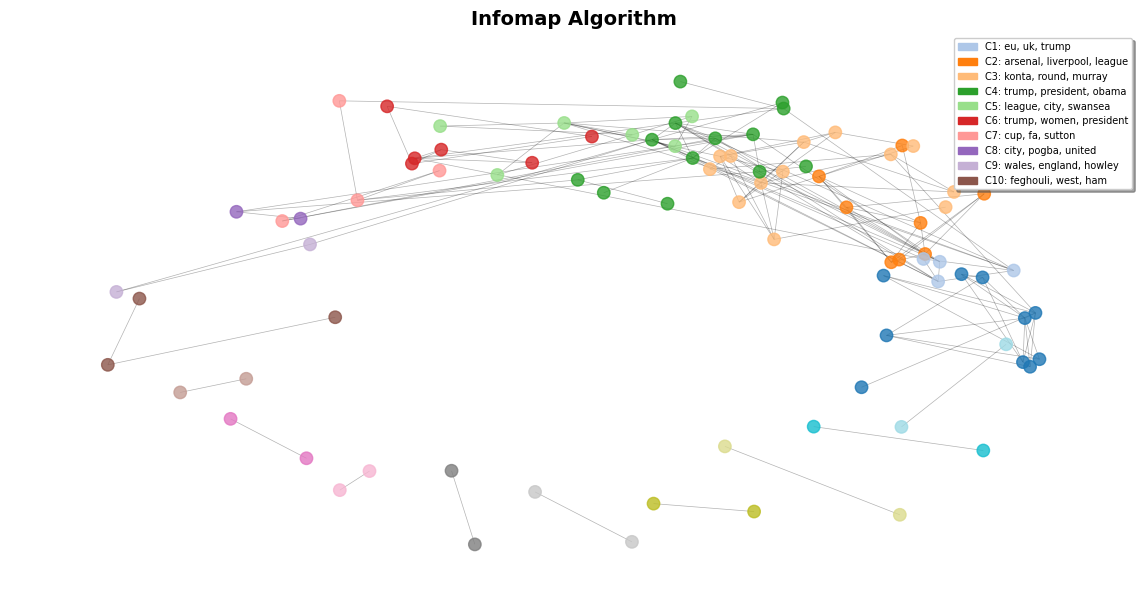

In [33]:
# Plot 3: Infomap
colors = [partition_louvain[node] for node in G.nodes()]
unique_comms = sorted(set(colors))
num_comms = len(unique_comms)

width = max(28, num_comms * 2)  # Increased width for 4 subplots
plt.figure(figsize=(width, 16))
plt.subplot(2, 2, 3)
colors = [partition_infomap[node] for node in G.nodes()]
unique_comms = sorted(set(colors))
nx.draw_networkx_nodes(G, pos_infomap, node_size=80, node_color=colors, 
                      cmap=plt.cm.tab20, alpha=0.8)
nx.draw_networkx_edges(G, pos_infomap, alpha=0.3, width=0.5, edge_color='black')

patches = []
for i in unique_comms[:min(10, len(unique_comms))]:
    if i in community_keywords_infomap:
        keywords = community_keywords_infomap[i]
        if len(keywords) > 30:
            keywords = keywords[:27] + "..."
        patches.append(mpatches.Patch(color=plt.cm.tab20(i/len(unique_comms)),
                                     label=f"C{i}: {keywords}"))

plt.legend(handles=patches, loc="upper right", bbox_to_anchor=(1.0, 1.0), 
          fontsize=7, frameon=True, fancybox=True, shadow=True)
plt.title("Infomap Algorithm", fontsize=14, fontweight='bold')
plt.axis("off")


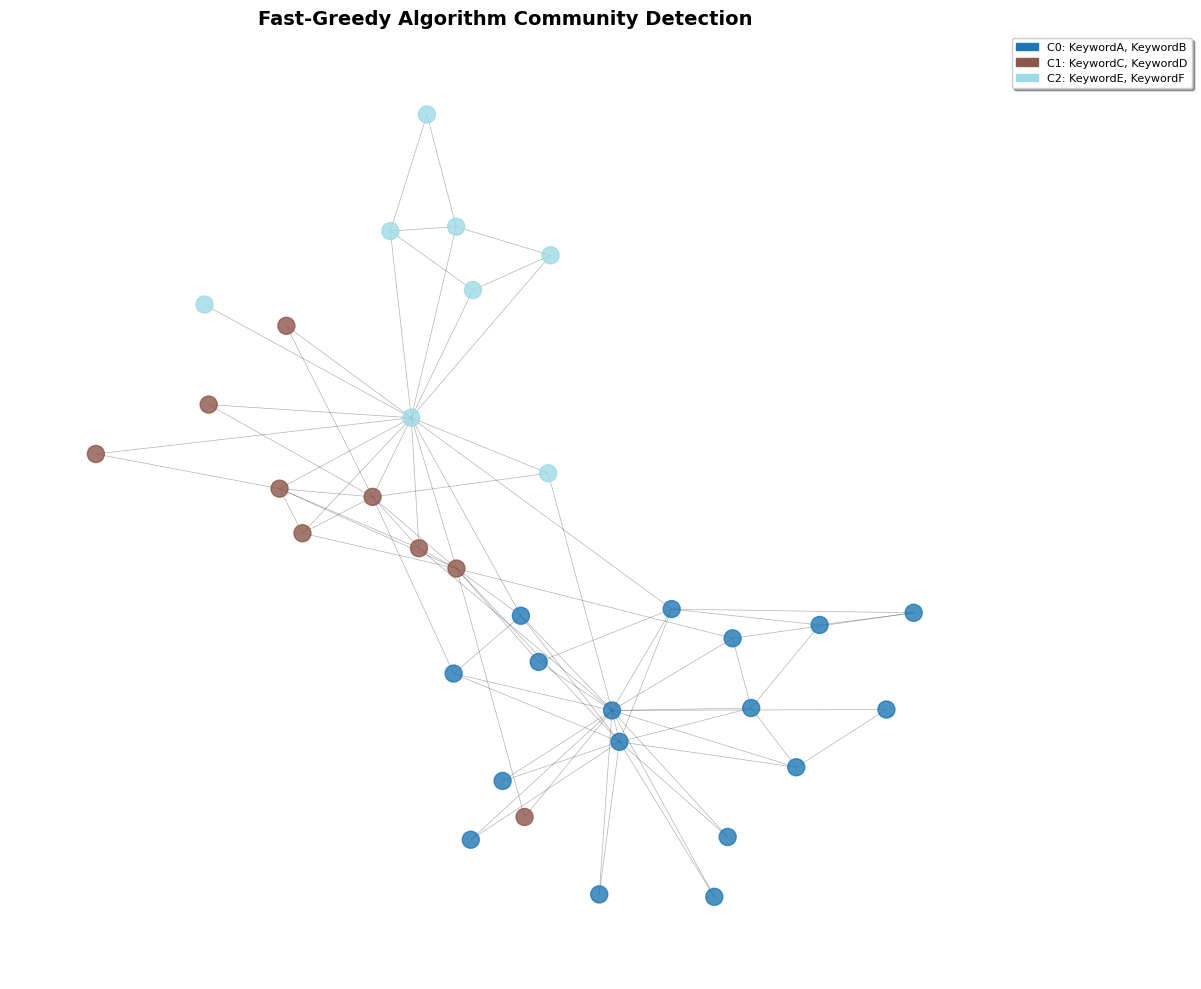

In [34]:

# --- 1. SETUP: Create or Load your Graph G ---
G = nx.karate_club_graph()  # Example: Using the built-in Karate Club graph

# --- 2. ALGORITHM: Run Fast-Greedy (Greedy Modularity) ---
# This returns a list of sets: [{node1, node2}, {node3, node4}, ...]
communities_fastgreedy = list(greedy_modularity_communities(G))

# FIX: Convert the list of sets into a dictionary {node: community_id}
partition_fastgreedy = {}
for community_id, community_nodes in enumerate(communities_fastgreedy):
    for node in community_nodes:
        partition_fastgreedy[node] = community_id

# Placeholder for your keywords (C0, C1, etc.)
# If you have these defined already, you can skip this part
community_keywords_fastgreedy = {
    0: "KeywordA, KeywordB",
    1: "KeywordC, KeywordD",
    2: "KeywordE, KeywordF"
}

# --- 3. VISUALIZATION ---
unique_comms = sorted(set(partition_fastgreedy.values()))
num_comms = len(unique_comms)

width = max(12, num_comms * 2) 
plt.figure(figsize=(width, 10))
pos_fastgreedy = nx.spring_layout(G, seed=42)

# Create the subplot (using 1, 1, 1 for a single plot, or 2, 2, 4 as in your snippet)
plt.subplot(1, 1, 1)

# Map nodes to colors based on their community ID
node_colors = [partition_fastgreedy[node] for node in G.nodes()]

# Draw Nodes
nx.draw_networkx_nodes(G, pos_fastgreedy, node_size=150, node_color=node_colors, 
                       cmap=plt.cm.tab20, alpha=0.8)

# Draw Edges
nx.draw_networkx_edges(G, pos_fastgreedy, alpha=0.3, width=0.5, edge_color='black')

# Create Legend Patches
patches = []
for i in unique_comms:
    if i in community_keywords_fastgreedy:
        keywords = community_keywords_fastgreedy[i]
        if len(keywords) > 30:
            keywords = keywords[:27] + "..."
        # Get color from the same colormap used in draw_networkx_nodes
        color = plt.cm.tab20(i / max(1, len(unique_comms)-1))
        patches.append(mpatches.Patch(color=color, label=f"C{i}: {keywords}"))

plt.legend(handles=patches, loc="upper right", bbox_to_anchor=(1.2, 1.0), 
           fontsize=8, frameon=True, shadow=True)

plt.title("Fast-Greedy Algorithm Community Detection", fontsize=14, fontweight='bold')
plt.axis("off")
plt.tight_layout()
plt.show()


In [35]:
# --- 1. Prepare Data ---
# NetworkX graphs need coordinates for K-Means/DBSCAN.
# We use spring_layout to generate 2D features for each node.
pos = nx.spring_layout(G, seed=42)
X = np.array([pos[node] for node in G.nodes()])

# --- 2. Run Algorithms ---
# K-Means (Centroid-based)
kmeans = KMeans(n_clusters=3, random_state=42).fit(X)
labels_kmeans = kmeans.labels_

# DBSCAN (Density-based)
dbscan = DBSCAN(eps=0.2, min_samples=3).fit(X)
labels_dbscan = dbscan.labels_

# --- 3. Custom Metric: Dunn Index ---
def dunn_index(X, labels):
    distances = squareform(pdist(X))
    unique_labels = np.unique(labels[labels != -1])
    if len(unique_labels) < 2: return 0
    
    inter_dist = []
    intra_dist = []
    
    for i in unique_labels:
        # Intra-cluster: max distance within the same cluster
        cluster_points = distances[np.ix_(labels == i, labels == i)]
        if cluster_points.size > 0:
            intra_dist.append(np.max(cluster_points))
        
        # Inter-cluster: min distance between different clusters
        for j in unique_labels:
            if i < j:
                inter_points = distances[np.ix_(labels == i, labels == j)]
                inter_dist.append(np.min(inter_points))
                
    return np.min(inter_dist) / np.max(intra_dist)

# --- 4. Evaluate & Print Results ---
def evaluate(name, labels):
    # Metrics only work if there's more than 1 cluster and it's not all noise
    if len(set(labels)) > 1:
        s_score = silhouette_score(X, labels)
        db_idx = davies_bouldin_score(X, labels)
        d_idx = dunn_index(X, labels)
        
        print(f"\n--- {name} Results ---")
        print(f"Silhouette Score (higher is better): {s_score:.4f}")
        print(f"Davies-Bouldin Index (lower is better): {db_idx:.4f}")
        print(f"Dunn Index (higher is better): {d_idx:.4f}")
    else:
        print(f"\n{name} failed to find valid clusters.")

evaluate("K-Means", labels_kmeans)
evaluate("DBSCAN", labels_dbscan)


--- K-Means Results ---
Silhouette Score (higher is better): 0.4504
Davies-Bouldin Index (lower is better): 0.7205
Dunn Index (higher is better): 0.1712

--- DBSCAN Results ---
Silhouette Score (higher is better): 0.2265
Davies-Bouldin Index (lower is better): 1.1453
Dunn Index (higher is better): 0.2176


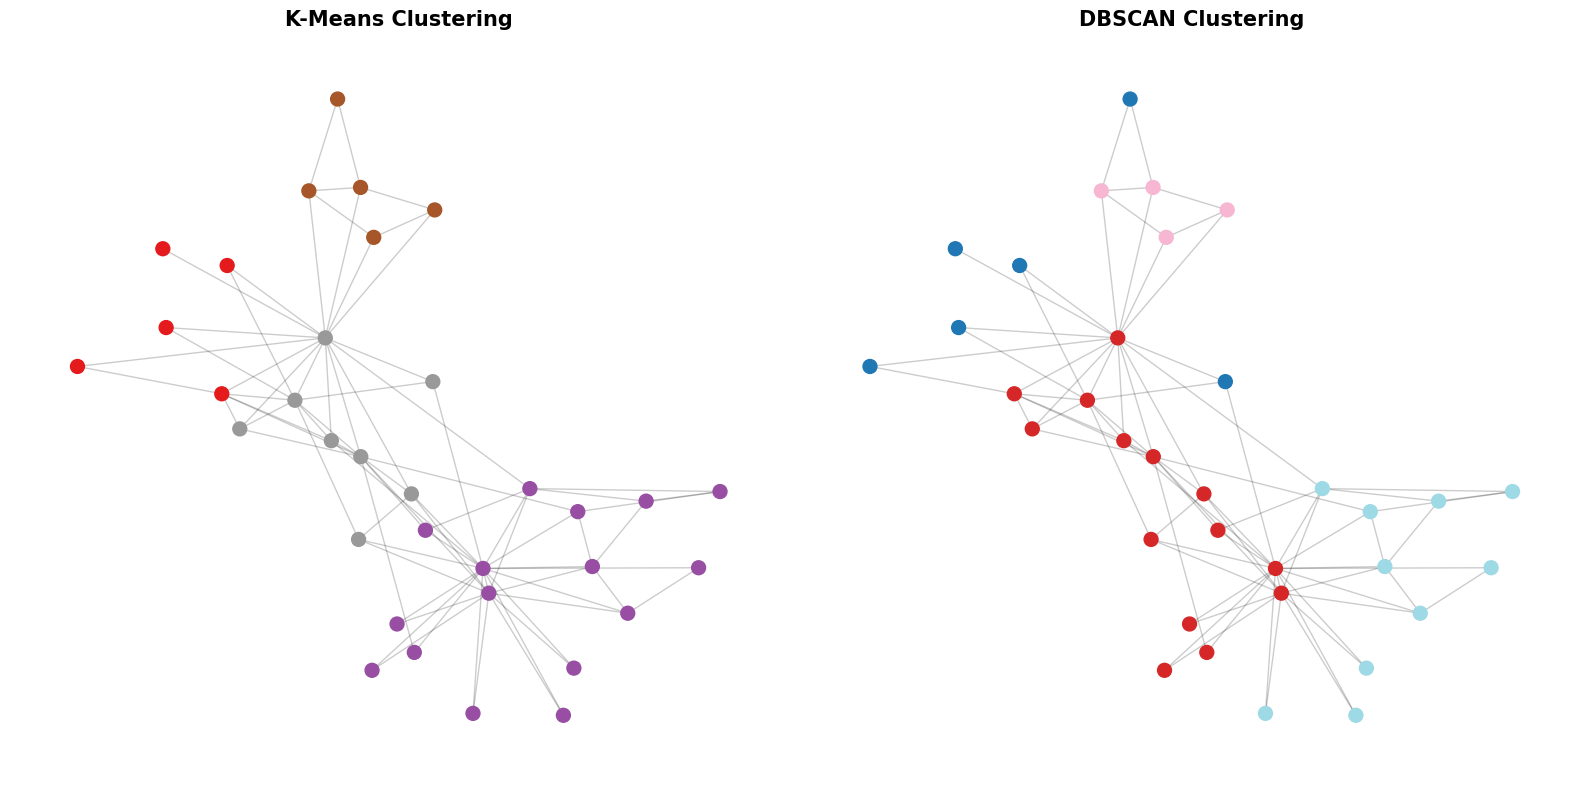

In [36]:
# 1. Generate layout coordinates for clustering and plotting
pos = nx.spring_layout(G, seed=42)
# Convert coordinates into a 2D array for scikit-learn
X = [pos[node] for node in G.nodes()]

# 2. Compute Clusters
kmeans_labels = KMeans(n_clusters=4, random_state=42).fit_predict(X)
dbscan_labels = DBSCAN(eps=0.2, min_samples=3).fit_predict(X)

# 3. Setup Subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# --- Plot K-Means ---
ax1.set_title("K-Means Clustering", fontsize=15, fontweight='bold')
nx.draw_networkx_edges(G, pos, ax=ax1, alpha=0.2)
nx.draw_networkx_nodes(G, pos, ax=ax1, node_size=100, 
                       node_color=kmeans_labels, cmap=plt.cm.Set1)
ax1.axis('off')

# --- Plot DBSCAN ---
ax2.set_title("DBSCAN Clustering", fontsize=15, fontweight='bold')
nx.draw_networkx_edges(G, pos, ax=ax2, alpha=0.2)
# Note: DBSCAN uses -1 for noise/outliers (often shown as black/grey)
nx.draw_networkx_nodes(G, pos, ax=ax2, node_size=100, 
                       node_color=dbscan_labels, cmap=plt.cm.tab20)
ax2.axis('off')

plt.tight_layout()
plt.show()